In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
import itertools
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
import itertools
import math
import seaborn as sns
import pickle
import scipy

In [4]:
read_file = pd.read_csv (r'/Volumes/SSD_Yue/TCGA_Data/brca_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt', sep='\t')
read_file = read_file[~read_file.Hugo_Symbol.isnull()]
read_file.index=read_file.Hugo_Symbol
read_file.drop(['Hugo_Symbol', 'Entrez_Gene_Id'],axis=1, inplace=True)
read_file=np.log2(read_file+1)
read_file=read_file.T
read_file.index=[i[0:12] for i in read_file.index]
read_file_2=read_file.groupby(read_file.columns.values,axis=1).mean()
basal_information=pd.read_csv('/Volumes/SSD_Yue/TCGA_Data/PAM50CLOW.csv')
list_basal=basal_information[basal_information.newSUBTYPE=='Basal'].iloc[:,0].tolist()

In [5]:
whole_genome=read_file_2.columns.tolist()

In [6]:
df_exp_tnbc=read_file_2[read_file_2.index.isin(list_basal)]

In [7]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

### We first did a genome wide DBscan for all breast cancer samples. For each gene, DBscan is run from eps 0.1 to 1.2 every 0.01 (111 eps). For every cluster pair generated for each gene, we calculate the number of TNBC samples in each cluster of the pair, the centroid distance for this cluster pair, the centroid separation (vertical and horizontal).

In [ ]:
gene_index_list=[]
eps_list=[]
cluster_number_list=[]
pan_cancer_distribution_list=[]
TNBC_distribution_list=[]

cluster_combination_list=[]
TNBC_distribution_in_this_cluster_list=[]
centroid_distance_list=[]
cluster_vertical_separation_list=[]
cluster_horizontal_separation_list=[]

for i in whole_genome:
    for j in list_eps:
        df_tmp = read_file_2[['MYC', i]]
        df_tmp_t = StandardScaler().fit_transform(df_tmp)
        db = DBSCAN(eps=j, min_samples=10).fit(df_tmp_t)
        labels = db.labels_
        df_tmp.insert(2, 'labels', labels)
        #df_tmp['labels']= labels
        realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)
        clusterNum = len(set(labels)) # including the noise cluster
        
    
    

        
        pan_cancer_distibution={}
        df_dis=df_tmp['labels'].value_counts().to_frame()
        
        for h in df_dis.index.tolist():
            pan_cancer_distibution[str(h)]=df_dis.loc[h, 'labels']
        
        
        #s_score_dict={}
        #for subset in itertools.combinations(set(labels), 2):
        #    df_test = df_tmp[(df_tmp.labels==subset[0]) | (df_tmp.labels==subset[1])]
        #    V = df_test[['MYC',i]].values
        #    v_labels = df_test['labels'].tolist()
        #    score = silhouette_score(V, v_labels, metric='euclidean')
        #    s_score_dict[subset]=score
        #silhouette_score_list.append(s_score_dict)
        
        TNBC_distibution={}
        df_tnbc_dis=df_tmp[df_tmp.index.isin(list_basal)]['labels'].value_counts().to_frame()
        for k in df_tnbc_dis.index.tolist():
            TNBC_distibution[str(k)]=df_tnbc_dis.loc[k, 'labels']

        if len(set(labels))<2:
            gene_index_list.append(i)
            eps_list.append(j)
            cluster_number_list.append(clusterNum)
            pan_cancer_distribution_list.append(pan_cancer_distibution)
            TNBC_distribution_list.append(TNBC_distibution)
            cluster_combination_list.append(np.nan)
            TNBC_distribution_in_this_cluster_list.append(np.nan)
            cluster_vertical_separation_list.append(np.nan)
            cluster_horizontal_separation_list.append(np.nan)
            centroid_distance_list.append(np.nan)
        else:
            for subset in itertools.combinations(set(labels), 2):
                gene_index_list.append(i)
                eps_list.append(j)
                cluster_number_list.append(clusterNum)
                pan_cancer_distribution_list.append(pan_cancer_distibution)
                TNBC_distribution_list.append(TNBC_distibution)
            
                cluster_combination_list.append(subset)
            
                df_tmp_1=df_tmp[df_tmp.labels==subset[0]]
                df_tmp_2=df_tmp[df_tmp.labels==subset[1]]
            
                TNBC_in_this_cluster_distribution={}
            
                TNBC_in_this_cluster_distribution[subset[0]]=df_tmp_1[df_tmp_1.index.isin(list_basal)].shape[0]
                TNBC_in_this_cluster_distribution[subset[1]]=df_tmp_2[df_tmp_2.index.isin(list_basal)].shape[0]
            
                TNBC_distribution_in_this_cluster_list.append(TNBC_in_this_cluster_distribution)
            
                if max(df_tmp_1[i]) >= max(df_tmp_2[i]):
                    cluster_vertical_separation_list.append(min(df_tmp_1[i])-max(df_tmp_2[i]))
                else:
                    cluster_vertical_separation_list.append(min(df_tmp_2[i])-max(df_tmp_1[i])) 
                
                if max(df_tmp_1['MYC']) >= max(df_tmp_2['MYC']):
                    cluster_horizontal_separation_list.append(min(df_tmp_1['MYC'])-max(df_tmp_2['MYC']))
                else:
                    cluster_horizontal_separation_list.append(min(df_tmp_2['MYC'])-max(df_tmp_1['MYC'])) 
            
        
                centroid_1=centeroidnp(np.asanyarray(df_tmp_1[['MYC', i]]))
                centroid_2=centeroidnp(np.asanyarray(df_tmp_2[['MYC', i]]))
        
                subset_distance=math.dist(centroid_1, centroid_2)
                centroid_distance_list.append(subset_distance)
        
        
df_results_1=pd.DataFrame(list(zip(gene_index_list, eps_list, cluster_number_list, pan_cancer_distribution_list, TNBC_distribution_list, cluster_combination_list,
                     TNBC_distribution_in_this_cluster_list, centroid_distance_list, cluster_vertical_separation_list, cluster_horizontal_separation_list)),
               columns =['gene', 'eps', 'pan_cancer_cluster_number', 'pan_cancer_distribution', 'TNBC_distribution', 'cluster_combination', 'TNBC_distribution_in_this_cluster', 'centroid_distance_for_this_cluster', 'vertical_separation_for_this_cluster', 'horizontal_separation_for_this_cluster'])
#df_results_1.to_csv('20000_20510_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')

### Then we did a first-round filtering chooseing genes with cluster pair distances more than 4 (higher than 95% of the quantile) and there are no less than 10 TNBC samples in each cluster of the pair.

In [39]:
df_all_1=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/TCGA_selecting_TNBC_cellualr_state_genes_across_the_genome/0_2000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_1=df_all_1[(df_all_1.centroid_distance_for_this_cluster>4)]
df_all_1['TNBC_distribution_in_this_cluster']=df_all_1['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_1= df_all_1[~df_all_1['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_1=df_all_1[df_all_1['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>0 for key  in list(x.keys())]== [True, True])]

In [41]:
df_all_2=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/TCGA_selecting_TNBC_cellualr_state_genes_across_the_genome/2000_4000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_2=df_all_2[(df_all_2.centroid_distance_for_this_cluster>4)]
df_all_2['TNBC_distribution_in_this_cluster']=df_all_2['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_2= df_all_2[~df_all_2['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_2=df_all_2[df_all_2['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>0 for key  in list(x.keys())]== [True, True])]

In [43]:
df_all_3=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/TCGA_selecting_TNBC_cellualr_state_genes_across_the_genome/4000_6000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_3=df_all_3[(df_all_3.centroid_distance_for_this_cluster>4)]
df_all_3['TNBC_distribution_in_this_cluster']=df_all_3['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_3= df_all_3[~df_all_3['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_3=df_all_3[df_all_3['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>0 for key  in list(x.keys())]== [True, True])]

In [45]:
df_all_4=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/TCGA_selecting_TNBC_cellualr_state_genes_across_the_genome/6000_8000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_4=df_all_4[(df_all_4.centroid_distance_for_this_cluster>4)]
df_all_4['TNBC_distribution_in_this_cluster']=df_all_4['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_4= df_all_4[~df_all_4['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_4=df_all_4[df_all_4['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>0 for key  in list(x.keys())]== [True, True])]

In [46]:
df_all_5=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/TCGA_selecting_TNBC_cellualr_state_genes_across_the_genome/8000_10000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_5=df_all_5[(df_all_5.centroid_distance_for_this_cluster>4)]
df_all_5['TNBC_distribution_in_this_cluster']=df_all_5['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_5= df_all_5[~df_all_5['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_5=df_all_5[df_all_5['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>0 for key  in list(x.keys())]== [True, True])]

In [48]:
df_all_6=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/TCGA_selecting_TNBC_cellualr_state_genes_across_the_genome/10000_12000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_6=df_all_6[(df_all_6.centroid_distance_for_this_cluster>4)]
df_all_6['TNBC_distribution_in_this_cluster']=df_all_6['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_6= df_all_6[~df_all_6['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_6=df_all_6[df_all_6['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>0 for key  in list(x.keys())]== [True, True])]

In [49]:
df_all_7=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/TCGA_selecting_TNBC_cellualr_state_genes_across_the_genome/12000_14000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_7=df_all_7[(df_all_7.centroid_distance_for_this_cluster>4)]
df_all_7['TNBC_distribution_in_this_cluster']=df_all_7['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_7= df_all_7[~df_all_7['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_7=df_all_7[df_all_7['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>0 for key  in list(x.keys())]== [True, True])]

In [50]:
df_all_8=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/TCGA_selecting_TNBC_cellualr_state_genes_across_the_genome/14000_16000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_8=df_all_8[(df_all_8.centroid_distance_for_this_cluster>4)]
df_all_8['TNBC_distribution_in_this_cluster']=df_all_8['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_8= df_all_8[~df_all_8['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_8=df_all_8[df_all_8['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>0 for key  in list(x.keys())]== [True, True])]

In [51]:
df_all_9=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/TCGA_selecting_TNBC_cellualr_state_genes_across_the_genome/16000_18000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_9=df_all_9[(df_all_9.centroid_distance_for_this_cluster>4)]
df_all_9['TNBC_distribution_in_this_cluster']=df_all_9['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_9= df_all_9[~df_all_9['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_9=df_all_9[df_all_9['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>0 for key  in list(x.keys())]== [True, True])]

In [52]:
df_all_10=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/TCGA_selecting_TNBC_cellualr_state_genes_across_the_genome/18000_20000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_10=df_all_10[(df_all_10.centroid_distance_for_this_cluster>4)]
df_all_10['TNBC_distribution_in_this_cluster']=df_all_10['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_10= df_all_10[~df_all_10['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_10=df_all_10[df_all_10['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>0 for key  in list(x.keys())]== [True, True])]

In [53]:
df_all_11=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/TCGA_selecting_TNBC_cellualr_state_genes_across_the_genome/20000_20510_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_11=df_all_11[(df_all_11.centroid_distance_for_this_cluster>4)]
df_all_11['TNBC_distribution_in_this_cluster']=df_all_11['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_11= df_all_11[~df_all_11['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_11=df_all_11[df_all_11['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>0 for key  in list(x.keys())]== [True, True])]

In [54]:
df_all=df_all_1.append([df_all_2, df_all_3, df_all_4, df_all_5, df_all_6, df_all_7, df_all_8, df_all_9, df_all_10, df_all_11])

In [55]:
df_all['TNBC_number_in_the_first_cluster']=df_all['TNBC_distribution_in_this_cluster'].apply(lambda x: x[list(x.keys())[0]])

In [56]:
df_all['TNBC_number_in_the_second_cluster']=df_all['TNBC_distribution_in_this_cluster'].apply(lambda x: x[list(x.keys())[1]])

In [57]:
list_1=df_all['TNBC_number_in_the_first_cluster'].tolist()
list_2=df_all['TNBC_number_in_the_second_cluster'].tolist()
list_all=list_1+list_2

In [72]:
df_all_1=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/0_2000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_1=df_all_1[(df_all_1.centroid_distance_for_this_cluster>4)]
df_all_1['TNBC_distribution_in_this_cluster']=df_all_1['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_1= df_all_1[~df_all_1['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_1=df_all_1[df_all_1['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>=10 for key  in list(x.keys())]== [True, True])]

In [73]:
df_all_2=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/2000_4000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_2=df_all_2[(df_all_2.centroid_distance_for_this_cluster>4)]
df_all_2['TNBC_distribution_in_this_cluster']=df_all_2['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_2= df_all_2[~df_all_2['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_2=df_all_2[df_all_2['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>=10 for key  in list(x.keys())]== [True, True])]

In [74]:
df_all_3=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/4000_6000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_3=df_all_3[(df_all_3.centroid_distance_for_this_cluster>4)]
df_all_3['TNBC_distribution_in_this_cluster']=df_all_3['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_3= df_all_3[~df_all_3['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_3=df_all_3[df_all_3['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>=10 for key  in list(x.keys())]== [True, True])]

In [75]:
df_all_4=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/6000_8000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_4=df_all_4[(df_all_4.centroid_distance_for_this_cluster>4)]
df_all_4['TNBC_distribution_in_this_cluster']=df_all_4['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_4= df_all_4[~df_all_4['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_4=df_all_4[df_all_4['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>=10 for key  in list(x.keys())]== [True, True])]

In [76]:
df_all_5=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/8000_10000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_5=df_all_5[(df_all_5.centroid_distance_for_this_cluster>4)]
df_all_5['TNBC_distribution_in_this_cluster']=df_all_5['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_5= df_all_5[~df_all_5['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_5=df_all_5[df_all_5['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>=10 for key  in list(x.keys())]== [True, True])]

In [77]:
df_all_6=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/10000_12000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_6=df_all_6[(df_all_6.centroid_distance_for_this_cluster>4)]
df_all_6['TNBC_distribution_in_this_cluster']=df_all_6['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_6= df_all_6[~df_all_6['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_6=df_all_6[df_all_6['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>=10 for key  in list(x.keys())]== [True, True])]

In [78]:
df_all_7=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/12000_14000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_7=df_all_7[(df_all_7.centroid_distance_for_this_cluster>4)]
df_all_7['TNBC_distribution_in_this_cluster']=df_all_7['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_7= df_all_7[~df_all_7['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_7=df_all_7[df_all_7['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>=10 for key  in list(x.keys())]== [True, True])]

In [79]:
df_all_8=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/14000_16000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_8=df_all_8[(df_all_8.centroid_distance_for_this_cluster>4)]
df_all_8['TNBC_distribution_in_this_cluster']=df_all_8['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_8= df_all_8[~df_all_8['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_8=df_all_8[df_all_8['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>=10 for key  in list(x.keys())]== [True, True])]

In [80]:
df_all_9=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/16000_18000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_9=df_all_9[(df_all_9.centroid_distance_for_this_cluster>4)]
df_all_9['TNBC_distribution_in_this_cluster']=df_all_9['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_9= df_all_9[~df_all_9['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_9=df_all_9[df_all_9['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>=10 for key  in list(x.keys())]== [True, True])]

In [81]:
df_all_10=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/18000_20000_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_10=df_all_10[(df_all_10.centroid_distance_for_this_cluster>4)]
df_all_10['TNBC_distribution_in_this_cluster']=df_all_10['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_10= df_all_10[~df_all_10['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_10=df_all_10[df_all_10['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>=10 for key  in list(x.keys())]== [True, True])]

In [82]:
df_all_11=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/20000_20510_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12192022.csv')
df_all_11=df_all_11[(df_all_11.centroid_distance_for_this_cluster>4)]
df_all_11['TNBC_distribution_in_this_cluster']=df_all_11['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_all_11= df_all_11[~df_all_11['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_all_11=df_all_11[df_all_11['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>=10 for key  in list(x.keys())]== [True, True])]

In [83]:
df_all=df_all_1.append([df_all_2, df_all_3, df_all_4, df_all_5, df_all_6, df_all_7, df_all_8, df_all_9, df_all_10, df_all_11])

In [84]:
df_all.shape

(5404, 11)

In [85]:
len(df_all.gene.unique().tolist())

757

In [86]:
list_first_filtered=df_all.gene.unique().tolist()

In [89]:
pd.DataFrame(list_first_filtered, columns=['gene']).to_csv('12192022_TCGA_gene_preliminary_list')

### So we got 753 genes after the first-round filtering. Then we sent these 753 genes for another round of DBscan. In this round, we did DBscan for only TNBC samples from eps 0.1 to 1.2 every 0.01. `min_sample` parameter is 8. The result is stored in `df_result`.

In [ ]:
#Second round DBscan filtering for only TNBC samples using the gene selected in the previous round using all breast cancer samples
gene_index_list=[]
eps_list=[]
cluster_number_list=[]
TNBC_distribution_list=[]

cluster_combination_list=[]
TNBC_distribution_in_this_cluster_list=[]
centroid_distance_list=[]
cluster_vertical_separation_list=[]
cluster_horizontal_separation_list=[]

for i in list_second_round:
    for j in list_eps:
        df_tmp = df_exp_tnbc[['MYC', i]]
        df_tmp_t = StandardScaler().fit_transform(df_tmp)
        db = DBSCAN(eps=j, min_samples=8).fit(df_tmp_t)
        labels = db.labels_
        df_tmp.insert(2, 'labels', labels)
        #df_tmp['labels']= labels
        realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)
        clusterNum = len(set(labels)) # including the noise cluster
        
    
    

        
        TNBC_distibution={}
        df_dis=df_tmp['labels'].value_counts().to_frame()
        
        for h in df_dis.index.tolist():
            TNBC_distibution[str(h)]=df_dis.loc[h, 'labels']
        
        
        #s_score_dict={}
        #for subset in itertools.combinations(set(labels), 2):
        #    df_test = df_tmp[(df_tmp.labels==subset[0]) | (df_tmp.labels==subset[1])]
        #    V = df_test[['MYC',i]].values
        #    v_labels = df_test['labels'].tolist()
        #    score = silhouette_score(V, v_labels, metric='euclidean')
        #    s_score_dict[subset]=score
        #silhouette_score_list.append(s_score_dict)
        

        if len(set(labels))<2:
            gene_index_list.append(i)
            eps_list.append(j)
            cluster_number_list.append(clusterNum)
            TNBC_distribution_list.append(TNBC_distibution)
            cluster_combination_list.append(np.nan)
            TNBC_distribution_in_this_cluster_list.append(np.nan)
            cluster_vertical_separation_list.append(np.nan)
            cluster_horizontal_separation_list.append(np.nan)
            centroid_distance_list.append(np.nan)
        else:
            for subset in itertools.combinations(set(labels), 2):
                gene_index_list.append(i)
                eps_list.append(j)
                cluster_number_list.append(clusterNum)
                TNBC_distribution_list.append(TNBC_distibution)
            
                cluster_combination_list.append(subset)
            
                df_tmp_1=df_tmp[df_tmp.labels==subset[0]]
                df_tmp_2=df_tmp[df_tmp.labels==subset[1]]
            
                TNBC_in_this_cluster_distribution={}
            
                TNBC_in_this_cluster_distribution[subset[0]]=df_tmp_1.shape[0]
                TNBC_in_this_cluster_distribution[subset[1]]=df_tmp_2.shape[0]
            
                TNBC_distribution_in_this_cluster_list.append(TNBC_in_this_cluster_distribution)
            
                if max(df_tmp_1[i]) >= max(df_tmp_2[i]):
                    cluster_vertical_separation_list.append(min(df_tmp_1[i])-max(df_tmp_2[i]))
                else:
                    cluster_vertical_separation_list.append(min(df_tmp_2[i])-max(df_tmp_1[i])) 
                
                if max(df_tmp_1['MYC']) >= max(df_tmp_2['MYC']):
                    cluster_horizontal_separation_list.append(min(df_tmp_1['MYC'])-max(df_tmp_2['MYC']))
                else:
                    cluster_horizontal_separation_list.append(min(df_tmp_2['MYC'])-max(df_tmp_1['MYC'])) 
            
        
                centroid_1=centeroidnp(np.asanyarray(df_tmp_1[['MYC', i]]))
                centroid_2=centeroidnp(np.asanyarray(df_tmp_2[['MYC', i]]))
        
                subset_distance=math.dist(centroid_1, centroid_2)
                centroid_distance_list.append(subset_distance)
        
        
df_result=pd.DataFrame(list(zip(gene_index_list, eps_list, cluster_number_list, TNBC_distribution_list, cluster_combination_list,
                     TNBC_distribution_in_this_cluster_list, centroid_distance_list, cluster_vertical_separation_list, cluster_horizontal_separation_list)),
               columns =['gene', 'eps', 'cluster_number', 'TNBC_distribution', 'cluster_combination', 'TNBC_distribution_in_this_cluster', 'centroid_distance_for_this_cluster', 'vertical_separation_for_this_cluster', 'horizontal_separation_for_this_cluster'])
df_result.to_csv('second_round_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12202022.csv')

In [100]:
df_result=pd.read_csv('/Volumes/SSD_Yue/TNBC_MYC_heterogeneity_data/TCGA_selecting_TNBC_cellualr_state_genes_across_the_genome/second_round_TCGA_TNBC_genome_wide_searching_for_genes_separating_cellular_states_another_method_eps_from_0.1_to_1.2_every_0.01_12202022.csv')

In [93]:
df_result.drop('Unnamed: 0', axis=1, inplace=True)

### Then we chose genes with cluster pairs that have centroid distance more than 4, and there are at least 8 TNBC samples in each cluster of the pair.

In [67]:
df_result_1=df_result[df_result.centroid_distance_for_this_cluster>4]
df_result_1['TNBC_distribution_in_this_cluster']=df_result_1['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_result_1= df_result_1[~df_result_1['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_result_1=df_result_1[df_result_1['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>0 for key  in list(x.keys())]== [True, True])]

<ipython-input-67-0aeab3deb180>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_1['TNBC_distribution_in_this_cluster']=df_result_1['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))


In [69]:
df_result_1['TNBC_number_in_the_first_cluster']=df_result_1['TNBC_distribution_in_this_cluster'].apply(lambda x: x[list(x.keys())[0]])
df_result_1['TNBC_number_in_the_second_cluster']=df_result_1['TNBC_distribution_in_this_cluster'].apply(lambda x: x[list(x.keys())[1]])

In [72]:
list_TNBC_1=df_result_1['TNBC_number_in_the_first_cluster'].tolist()
list_TNBC_2=df_result_1['TNBC_number_in_the_second_cluster'].tolist()
list_TNBC_all=list_TNBC_1+list_TNBC_2

In [108]:
len(df_result_1.gene.unique().tolist())

488

In [101]:
df_result_1=df_result[df_result.centroid_distance_for_this_cluster>4]
df_result_1['TNBC_distribution_in_this_cluster']=df_result_1['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))
df_result_1= df_result_1[~df_result_1['TNBC_distribution_in_this_cluster'].apply(lambda x: -1 in x.keys())]
df_result_1=df_result_1[df_result_1['TNBC_distribution_in_this_cluster'].apply(lambda x: [x[key]>=8 for key  in list(x.keys())]== [True, True])]

<ipython-input-101-2d3ea4659ac0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_1['TNBC_distribution_in_this_cluster']=df_result_1['TNBC_distribution_in_this_cluster'].apply(lambda x: eval(x))


In [102]:
df_to_plot=df_result_1.drop_duplicates('gene', keep='first')
df_to_plot['combination']=df_to_plot.apply(lambda x: str(x['gene']) + '_' + str(x['eps']), axis=1)

In [104]:
df_to_plot.to_csv('genes_separating_TCGA_TNBC_samples_comparing_against_BC_samples_12232022.csv')

<ipython-input-138-0ecb96a6447d>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


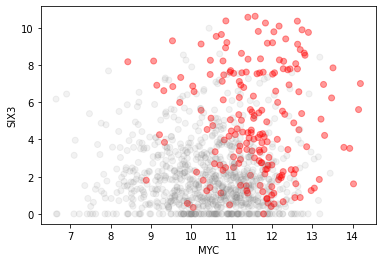

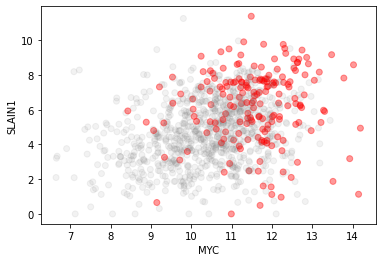

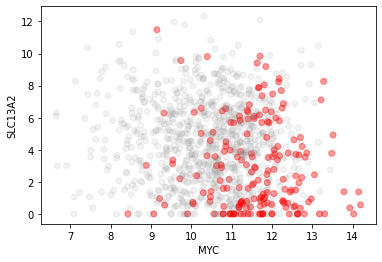

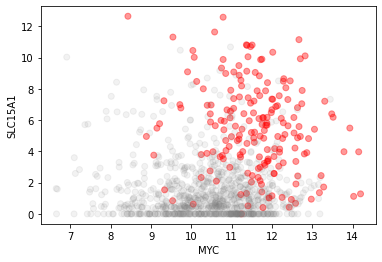

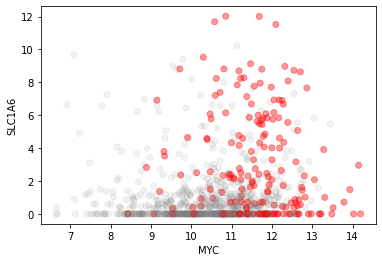

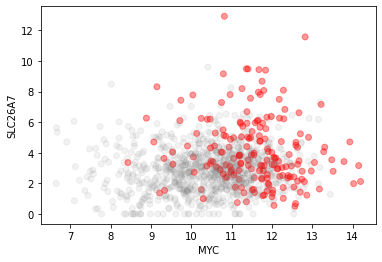

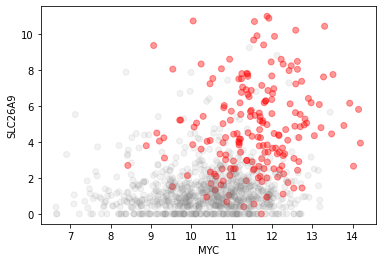

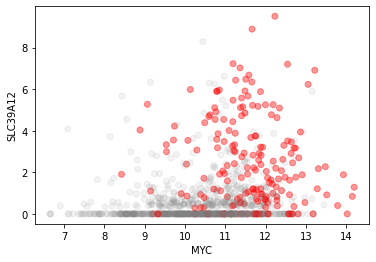

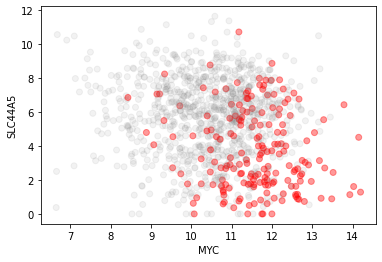

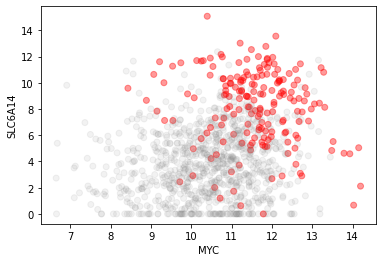

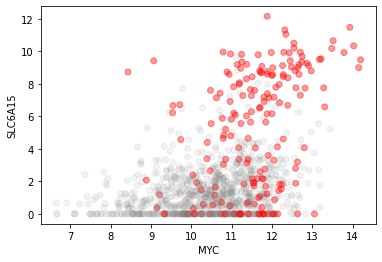

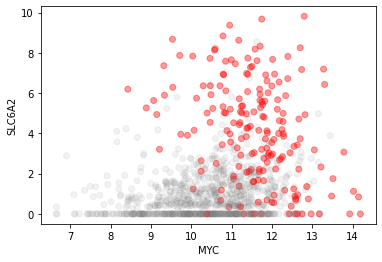

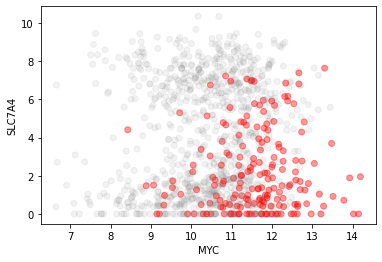

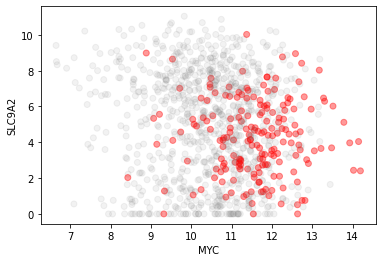

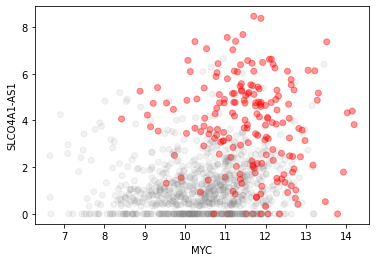

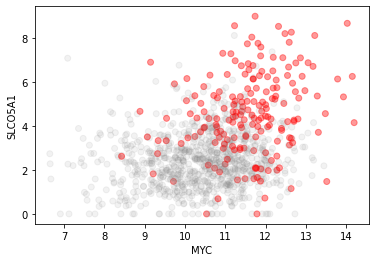

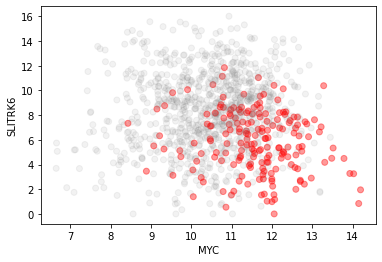

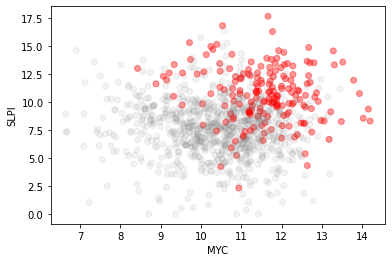

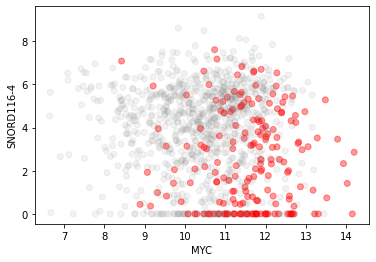

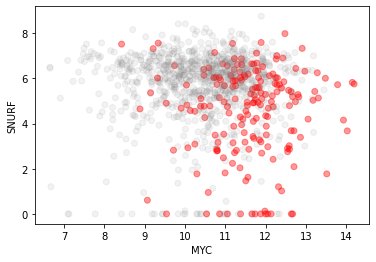

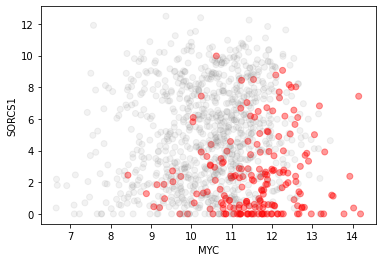

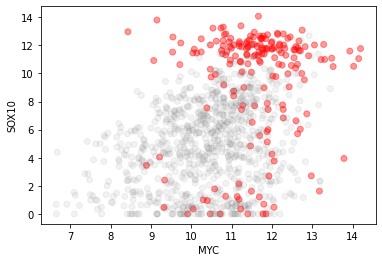

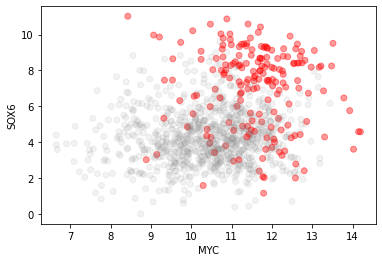

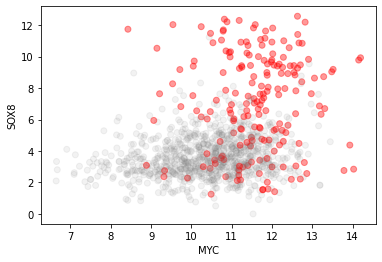

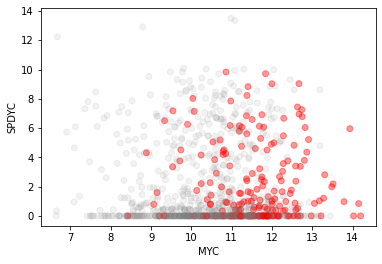

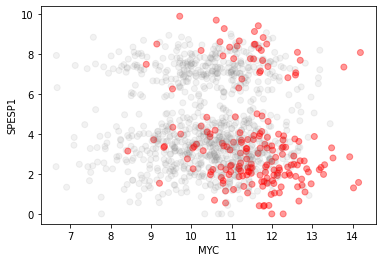

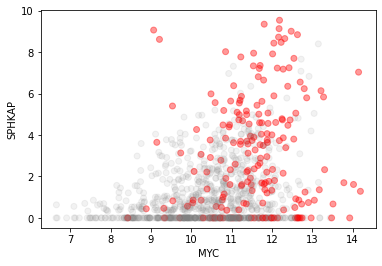

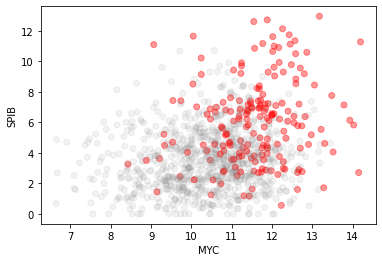

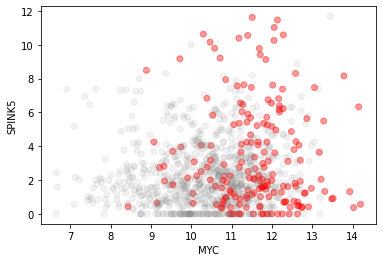

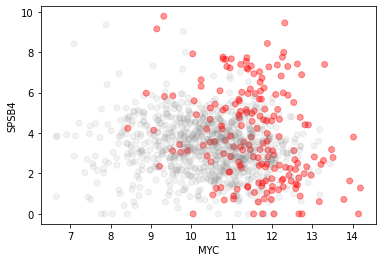

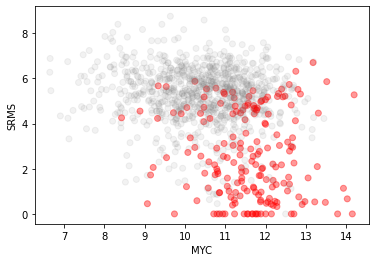

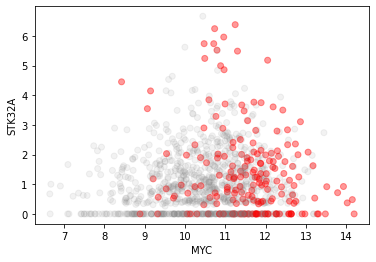

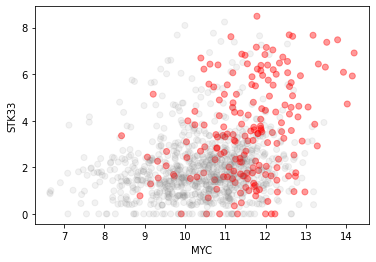

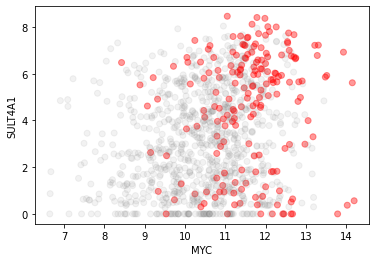

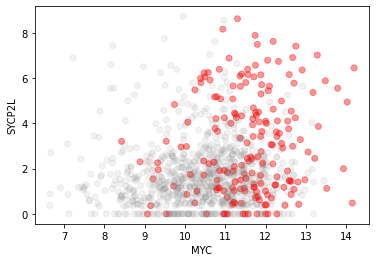

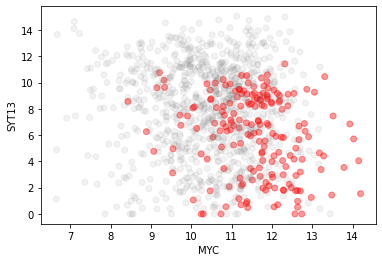

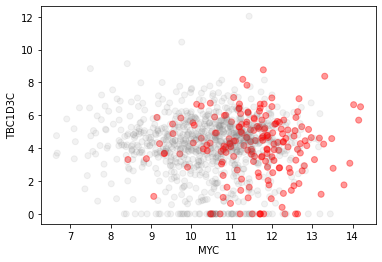

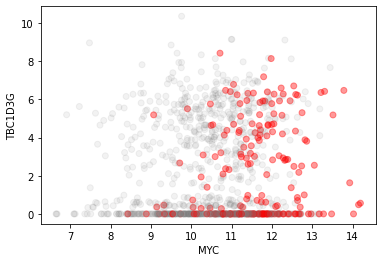

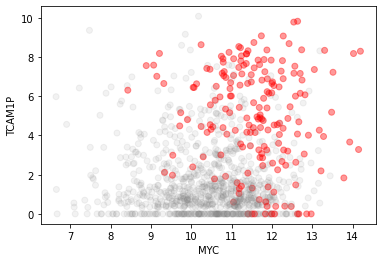

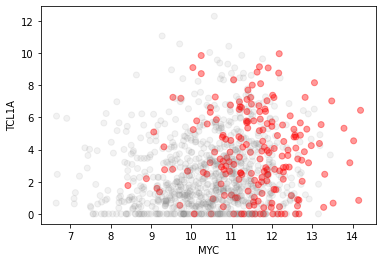

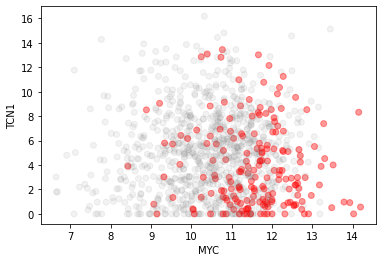

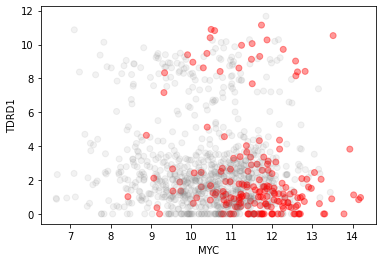

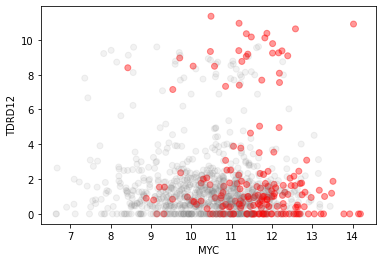

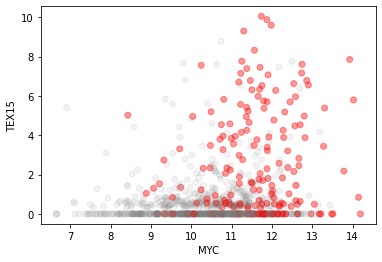

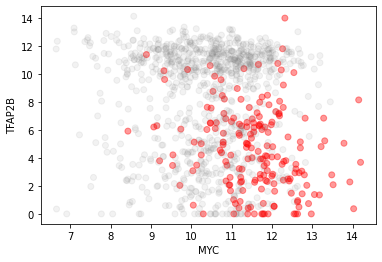

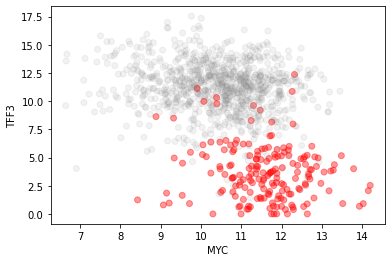

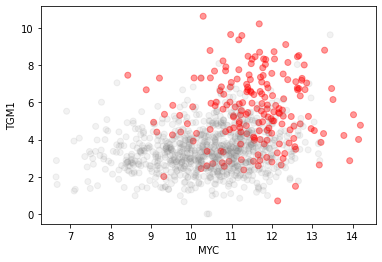

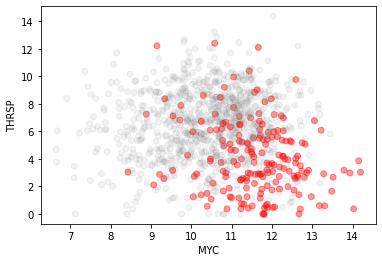

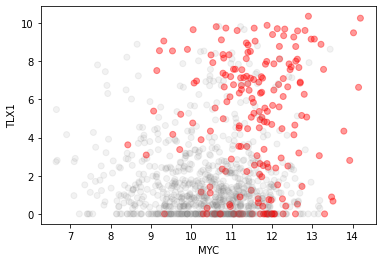

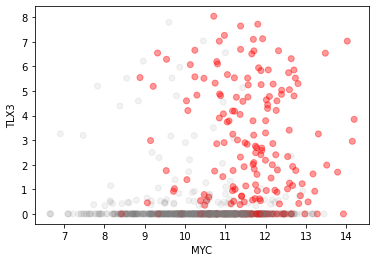

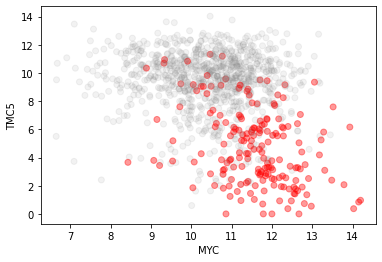

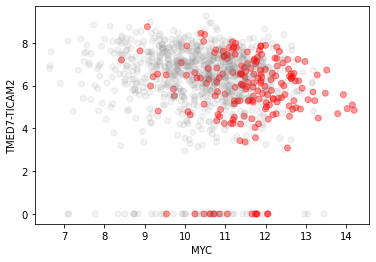

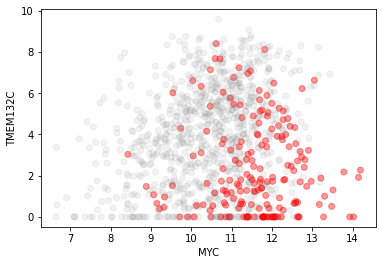

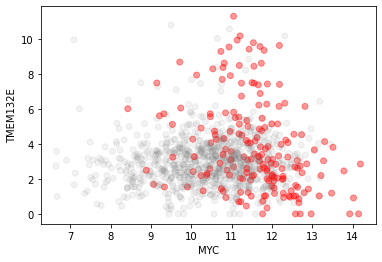

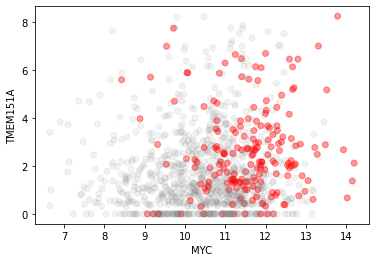

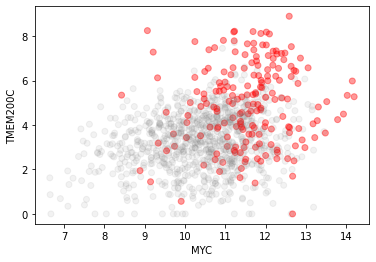

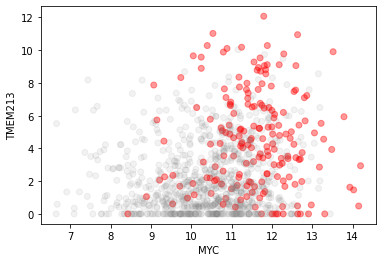

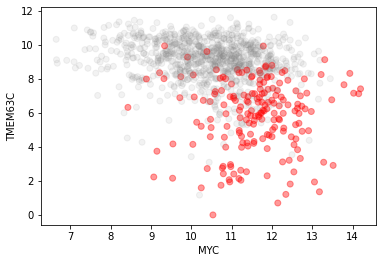

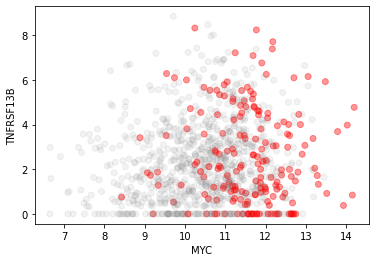

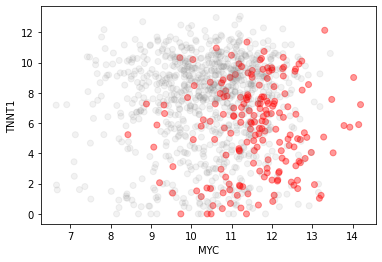

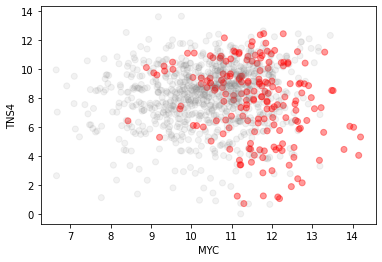

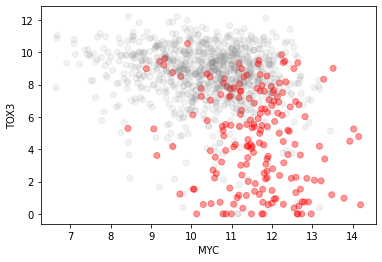

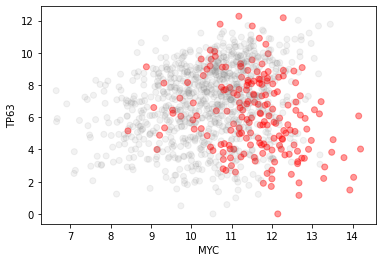

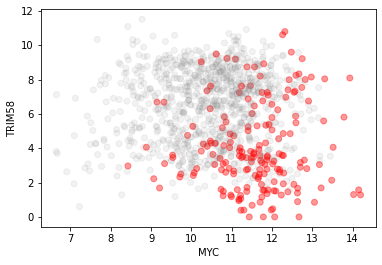

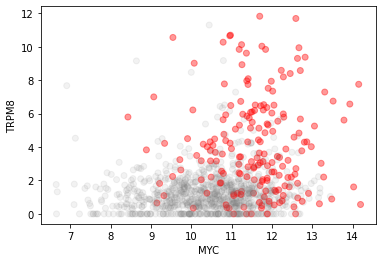

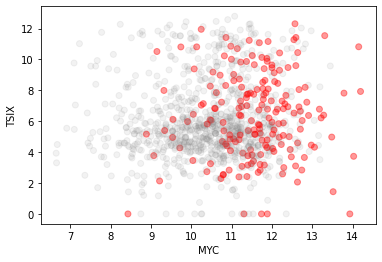

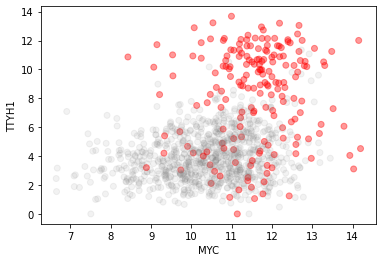

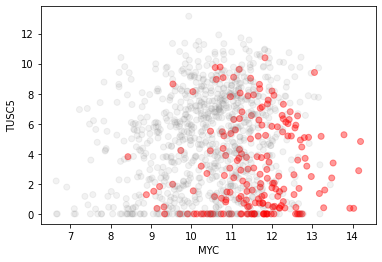

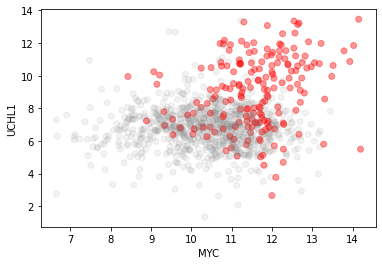

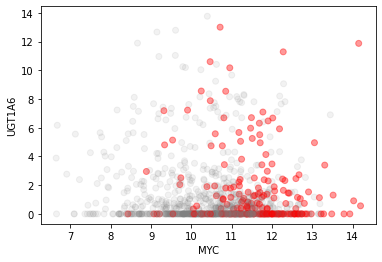

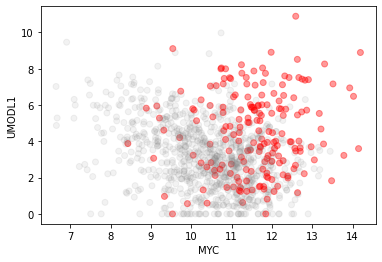

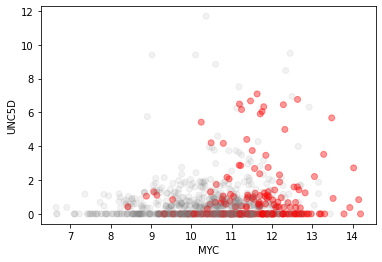

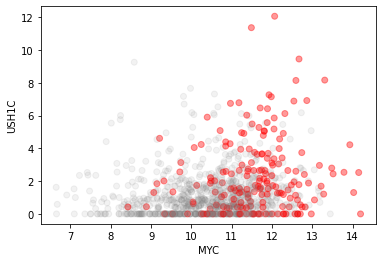

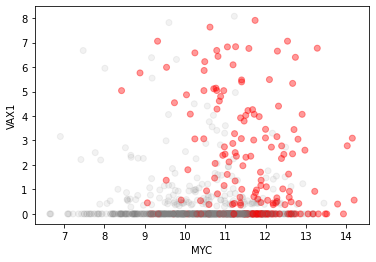

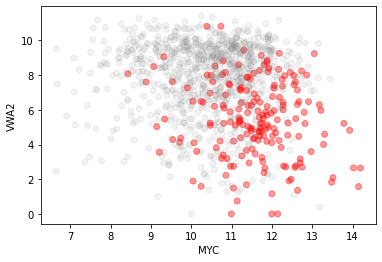

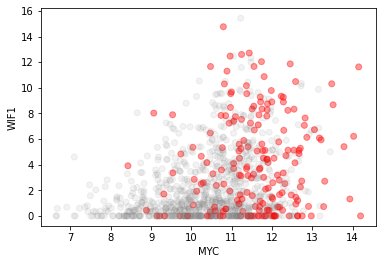

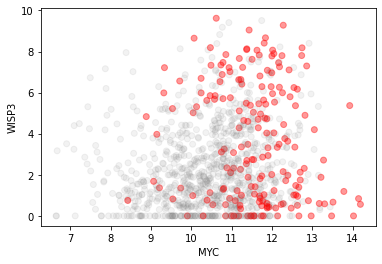

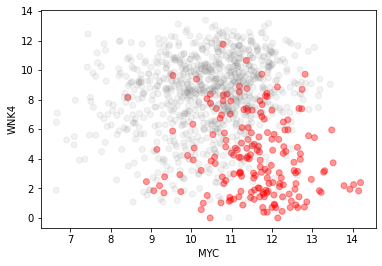

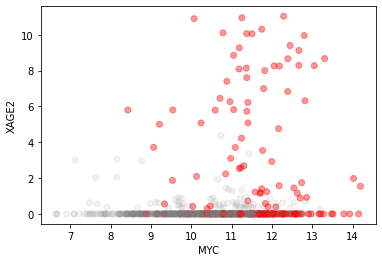

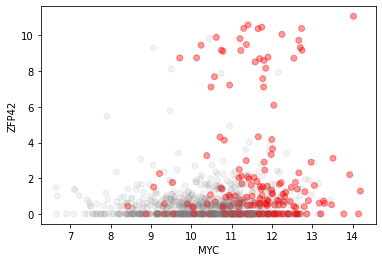

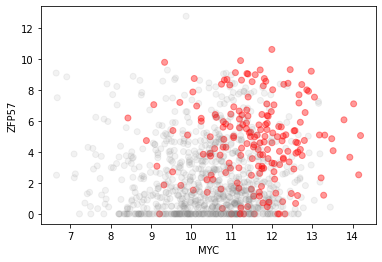

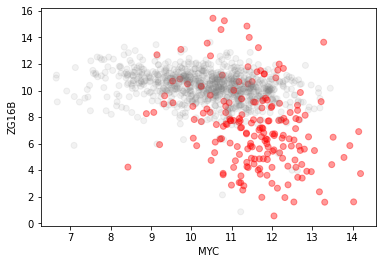

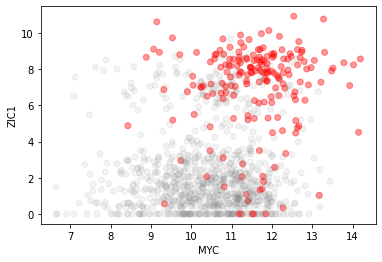

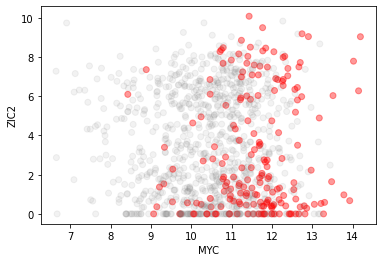

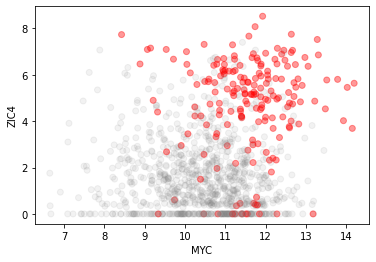

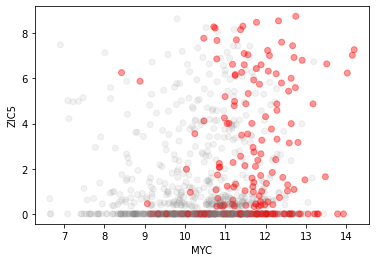

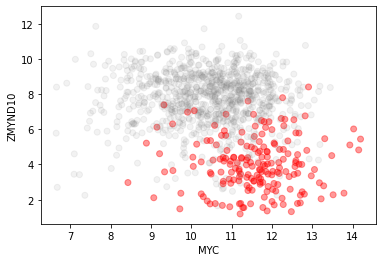

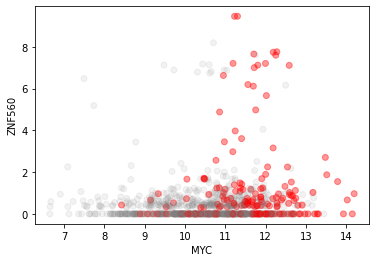

In [138]:
#To visualize the selected genes:
dict_map={-1: '#808080', 0: '#FFFF00', 1: '#008000', 2: '#FF8000', 3: '#FFC0CB', 4: '#800080', 5: '#FF7F50', 6: '#A52A2A', 7: '#32CD32', 8: '#EE82EE', 9: '#FF00FF', 10: '#808000', 11: '#FF7F50', 12: '#F5DEB3', 14: '#4B0082', 15: '#000080', 16:'#DDA0DD', 17: '#800000'}
for i in df_to_plot['combination'].tolist()[0:]:
    #df_tmp = df_exp_tnbc[['MYC', i.split('_')[0]]]
    #df_tmp_t = StandardScaler().fit_transform(df_tmp)
    #db = DBSCAN(eps=float(i.split('_')[1]), min_samples=8).fit(df_tmp_t)
    #labels = db.labels_
    #df_tmp['labels']= labels
    #df_tmp['alpha']=0.1
    #df_tmp['color']=df_tmp['labels'].map(dict_map)
    #list_labels=[i for i in df_tmp.labels.unique().tolist() if i is not -1]
    
    df_tmp_1=read_file_2[['MYC', i.split('_')[0]]]
    
    for j in df_tmp_1.index.tolist():
        if j in list_basal:
            df_tmp_1.loc[j, 'color']='red'
            df_tmp_1.loc[j, 'alpha']=0.4
        else:
            df_tmp_1.loc[j, 'color']='gray'
            df_tmp_1.loc[j, 'alpha']=0.1
    fig, ax = plt.subplots()
    ax.scatter(df_tmp_1['MYC'], df_tmp_1[i.split('_')[0]], c=df_tmp_1['color'].tolist(), alpha=df_tmp_1['alpha'].tolist())
    plt.xlabel("MYC")
    plt.ylabel(i.split('_')[0])
    plt.savefig('../../../Downloads/{}_vs_MYC_gene_expression_TCGA_12202022.png'.format(i.split('_')[0]), dpi=150)